In [1]:
%load_ext autoreload
%autoreload 2

import os 
import dotenv 
import sys

# Load the environment variables
dotenv.load_dotenv()

# Add the environment variable PROJECT_ROOT to the Python path
project_root = os.getenv('PROJECT_ROOT')
if project_root:
    sys.path.append(project_root)
    print(f"Added {project_root} to the Python path")
else:
    print("PROJECT_ROOT environment variable not found")

import importlib 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

Added /Volumes/CrucialX/project-akrav to the Python path


# Inspect a Weather GRIB File

## Load the GRIB

In [2]:
import xarray as xr

# Open the NetCDF file
import datetime
file_name = 1700265600
file_datetime = datetime.datetime.fromtimestamp(file_name)
print(f'Weather loaded for {file_datetime}')

file_path = os.path.join(project_root, 'data', 'wx', 'cdfs', f'{file_name}.nc')
ds = xr.open_dataset(file_path)

# Print dataset information
print(ds.info())

# Print detailed dataset information
print("\nDetailed Information:")
print(ds)

# Close the dataset
ds.close()

Weather loaded for 2023-11-18 01:00:00
xarray.Dataset {
dimensions:
	longitude = 111 ;
	latitude = 85 ;

variables:
	float64 longitude(longitude) ;
	float64 cape(latitude, longitude) ;
		cape:long_name = Convective Available Potential Energy ;
		cape:units = J/kg ;
		cape:standard_name = atmosphere_convective_available_potential_energy ;
	float64 cin(latitude, longitude) ;
		cin:long_name = Convective Inhibition ;
		cin:units = J/kg ;
		cin:standard_name = atmosphere_convective_inhibition ;
	float64 u_wind(latitude, longitude) ;
		u_wind:long_name = U-component of wind ;
		u_wind:units = m/s ;
		u_wind:standard_name = eastward_wind ;
	float64 v_wind(latitude, longitude) ;
		v_wind:long_name = V-component of wind ;
		v_wind:units = m/s ;
		v_wind:standard_name = northward_wind ;
	float64 wind_speed(latitude, longitude) ;
		wind_speed:long_name = Wind Speed ;
		wind_speed:units = m/s ;
		wind_speed:standard_name = wind_speed ;
	float64 latitude(latitude) ;

// global attributes:
	:descri

## Visualize the Wind Field

In [3]:
import cartopy.crs as ccrs
import cartopy

def plot_wind_field(ds):
    """
    Plots the wind field from an xarray Dataset on a map using Cartopy.
    Expects ds to have 'u_wind', 'v_wind', 'latitude', and 'longitude' variables.
    """
    # Extract data
    lons = ds['longitude'].values
    lats = ds['latitude'].values
    u = ds['u_wind'].values
    v = ds['v_wind'].values
    
    # Calculate wind speed if not already in the dataset
    if 'wind_speed' in ds:
        wind_speed = ds['wind_speed'].values
    else:
        wind_speed = np.sqrt(u**2 + v**2)

    # Create meshgrid for plotting
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Set up the map with Lambert Conformal projection centered on Europe
    central_longitude = (lons.min() + lons.max()) / 2
    central_latitude = (lats.min() + lats.max()) / 2
    projection = ccrs.LambertConformal(central_longitude=central_longitude, 
                                       central_latitude=central_latitude,
                                       standard_parallels=(35, 65))
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
    
    # Set map extent
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution='50m')
    ax.add_feature(cartopy.feature.LAND, facecolor='lightgrey')
    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

    # Plot wind magnitude as color mesh
    mesh = ax.pcolormesh(lon2d, lat2d, wind_speed, 
                        transform=ccrs.PlateCarree(),
                        cmap='viridis', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label('Wind Speed (m/s)')

    # Plot wind vectors (quiver) - transform from PlateCarree to our projection
    skip = (slice(None, None, 5), slice(None, None, 5))  # skip for clarity
    q = ax.quiver(lon2d[skip], lat2d[skip], u[skip], v[skip], 
                  transform=ccrs.PlateCarree(),
                  scale=1200, width=0.002, color='white') # input data is in PlateCarree

    ax.set_title(f'Wind Field @{file_datetime}Z\n200mbar CRZ ALT')
    plt.show()

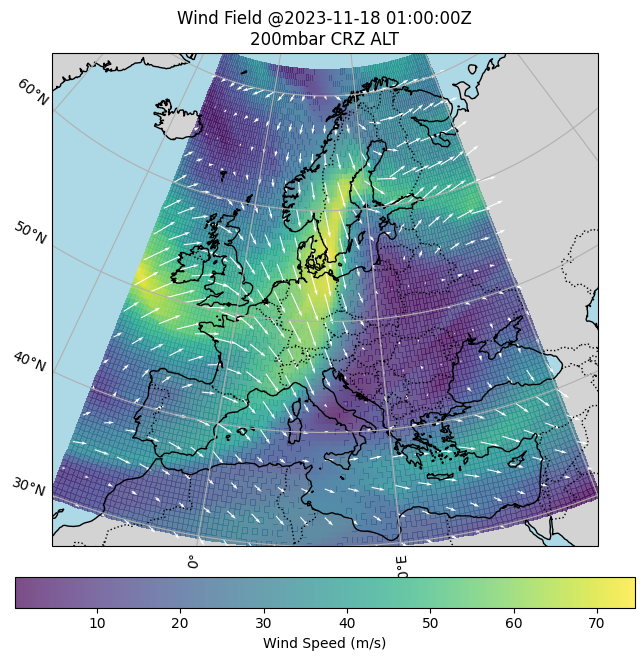

In [4]:
plot_wind_field(ds)

# Building the Graph Route Context Object (GRCO)

In [5]:
import importlib 
import networkx as nx
from quasar_r12.context import GraphRouteContext

In [6]:
Gm = nx.read_gml(os.path.join(project_root, 'quasar_r12', 'EGLL_LEMD.gml'))
print(f'Graph loaded with {Gm.number_of_nodes()} nodes and {Gm.number_of_edges()} edges')

Graph loaded with 425 nodes and 2256 edges


In [7]:
from quasar_r12.context import prepare_wind_property_args
ctx = GraphRouteContext(Gm)

In [8]:
to_add = prepare_wind_property_args(Gm, ds, file_name)

Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 458.51it/s]


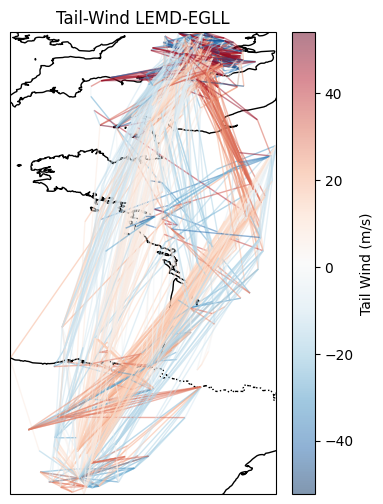

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------------
# 1) Filter out only the tail‐wind entries from to_add
# ------------------------------------------------------------------
# to_add is a list of tuples:
#   (u, v, prop_name, timestamps, altitudes, values)
tail_data = [
    (u, v, vals.flatten()[0])
    for u, v, prop_name, times, alts, vals in to_add
    if prop_name == "tail_wind"
]

# ------------------------------------------------------------------
# 2) Build line segments and corresponding wind‐speed array
# ------------------------------------------------------------------
segments = []
wind_speeds = []

for u, v, wind in tail_data:
    lon1, lat1 = Gm.nodes[u]["lon"], Gm.nodes[u]["lat"]
    lon2, lat2 = Gm.nodes[v]["lon"], Gm.nodes[v]["lat"]
    segments.append([(lon1, lat1), (lon2, lat2)])
    wind_speeds.append(wind)

wind_speeds = np.array(wind_speeds)

# ------------------------------------------------------------------
# 3) Plot with Cartopy + LineCollection
# ------------------------------------------------------------------
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# If you want to zoom in on your region, you can set extent:
min_lon, max_lon = np.min([s[0][0] for s in segments]), np.max([s[1][0] for s in segments])
min_lat, max_lat = np.min([s[0][1] for s in segments]), np.max([s[1][1] for s in segments])
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Create a LineCollection, coloring by tail-wind speed
norm = plt.Normalize(vmin=wind_speeds.min(), vmax=wind_speeds.max())
lc = LineCollection(
    segments,
    cmap="RdBu_r",  # Red-Blue diverging colormap with blue for negative, red for positive
    norm=norm,
    linewidths=1,
    transform=ccrs.PlateCarree(),
    alpha=0.5
)
lc.set_array(wind_speeds)
ax.add_collection(lc)

# Add colorbar
cbar = plt.colorbar(lc, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Tail Wind (m/s)")

ax.set_title("Tail‐Wind LEMD-EGLL")
plt.show()

# Automatic Context Building

In [10]:
import importlib 
import networkx as nx
from quasar_r12.context import GraphRouteContext

Gm = nx.read_gml(os.path.join(project_root, 'quasar_r12', 'EGLL_LEMD.gml'))
print(f'Graph loaded with {Gm.number_of_nodes()} nodes and {Gm.number_of_edges()} edges')

Graph loaded with 425 nodes and 2256 edges


In [67]:
from quasar_r12.context import prepare_wind_property_args
ctx = GraphRouteContext(Gm)

In [68]:
from datetime import datetime
from datetime import timezone
from_time = datetime(2023, 4, 1, 0, tzinfo=timezone.utc)
to_time = datetime(2023, 4, 2, 0, tzinfo=timezone.utc)
from_timestamp = int(from_time.timestamp())
to_timestamp = int(to_time.timestamp())
print(f'Time range: {from_timestamp} to {to_timestamp}')

Time range: 1680307200 to 1680393600


In [69]:
cdf_dir = os.path.join(project_root, 'data', 'wx', 'cdfs')

def find_nc_files_in_range(cdf_dir, from_timestamp, to_timestamp):
    """
    Finds .nc files in a directory whose base filename (as an integer timestamp)
    falls within a specified time range.

    Args:
        cdf_dir (str): The directory containing the .nc files.
        from_timestamp (int): The lower bound of the timestamp range (inclusive).
        to_timestamp (int): The upper bound of the timestamp range (inclusive).

    Returns:
        list: A list of full file paths for the admitted .nc files.
    """
    admitted_nc = []
    try:
        all_files = os.listdir(cdf_dir)
        for file_name in all_files:
            # Filter for .nc files that don't start with ._
            if file_name.endswith(".nc") and not file_name.startswith("._"):
                # Remove .nc extension to get the base name
                base_name = file_name[:-3]
                try:
                    # Convert base name to integer timestamp
                    timestamp = int(base_name)
                    # Check if timestamp is within the specified range
                    if from_timestamp <= timestamp <= to_timestamp:
                        # Add the full file path to the list
                        admitted_nc.append(os.path.join(cdf_dir, file_name))
                except ValueError:
                    # Ignore files whose base name is not a valid integer
                    continue
    except FileNotFoundError:
        print(f"Error: Directory not found at {cdf_dir}")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    
    admitted_nc.sort()
    return admitted_nc

admitted_ncs = find_nc_files_in_range(cdf_dir, from_timestamp, to_timestamp)
print(f'Found {len(admitted_ncs)} files to be read.')

Found 9 files to be read.


In [70]:
from tqdm import tqdm
import quasar_r12.context
importlib.reload(quasar_r12.context)
from quasar_r12.context import prepare_wind_property_args


for nc_file in admitted_ncs:
    print(f'Processing {nc_file}')
    # Get the base name of the file without the .nc extension and convert it to an integer timestamp
    file_name = os.path.basename(nc_file).replace('.nc', '')
    file_timestamp = int(file_name)
    # Open the NetCDF file
    ds = xr.open_dataset(nc_file)
    # Prepare the arguments for the function call `upsert_property_data`
    to_add = prepare_wind_property_args(Gm, ds, file_timestamp)
    # Upsert the data into the context object
    for u, v, prop_name, times, altitudes, values in to_add:
        ctx.upsert_property_data(u, v, prop_name, times, altitudes, values)
    

Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680307200.nc


Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 539.97it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680318000.nc


Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 552.59it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680328800.nc


Processing edges: 100%|██████████| 2256/2256 [00:03<00:00, 565.14it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680339600.nc


Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 560.30it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680350400.nc


Processing edges: 100%|██████████| 2256/2256 [00:03<00:00, 566.28it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680361200.nc


Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 555.44it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680372000.nc


Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 559.81it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680382800.nc


Processing edges: 100%|██████████| 2256/2256 [00:04<00:00, 555.05it/s]


Processing /Volumes/CrucialX/project-akrav/data/wx/cdfs/1680393600.nc


Processing edges: 100%|██████████| 2256/2256 [00:03<00:00, 566.20it/s]


In [71]:
print(ctx)

GraphRouteContext: 2256 edge(s) with data
 Edge (LFBX, ENHEL):
  - tail_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
  - cross_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
 Edge (BISKA_37, LFOT):
  - tail_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
  - cross_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
 Edge (BISKA_37, URUNA):
  - tail_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
  - cross_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
 Edge (LFCZ, ASKAN):
  - tail_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
  - cross_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
 Edge (SIE_06, DGO):
  - tail_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
  - cross_wind: times 1680307200.0 to 1680393600.0 (9 pts), alts 0.0 to 0.0 (9 pts)
 Edge (SIE_

In [77]:
save_dir = os.path.join(project_root, 'quasar_r12', 'ctx')
os.makedirs(save_dir, exist_ok=True)
ctx.save(os.path.join(save_dir, 'LEMD_EGLL_01042023.context'))
context_path = os.path.join(save_dir, 'LEMD_EGLL_01042023.context')
file_size_bytes = os.path.getsize(context_path)
print(f"Context file size: {file_size_bytes / 1024 / 1024 :.2f} MB, saved to {context_path}")

Context file size: 4.27 MB, saved to /Volumes/CrucialX/project-akrav/quasar_r12/ctx/LEMD_EGLL_01042023.context
